In [221]:
# import the library ..

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 2000)
from datetime import datetime
from fbprophet import Prophet
from sklearn.metrics import r2_score

In [168]:
#Load dataset
df = pd.read_csv('final_con.csv',index_col='Date')
df.index.freq = 'MS'


In [169]:
# look to the head of data-set 
df.head()

Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)  \
Date                                                                                   
1993-07-01                                             177380                          
1993-08-01                                             169446                          
1993-09-01                                             167090                          
1993-10-01                                             171262                          
1993-11-01                                             174098                          

            U.S. Gasoline Demand (Thousand Barrels per Day)  \
Date                                                          
1993-07-01                                             7788   
1993-08-01                                             7857   
1993-09-01                                             7559   
1993-10-01                                             7553   
1993-11-01                                             7507   

            Weekly U.S. Imports of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                     
1993-07-01                                                  0                            
1993-08-01                                                  0                            
1993-09-01                                                  0                            
1993-10-01                                                  0                            
1993-11-01                                                  0                            

            Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)  \
Date                                                                                               
1993-07-01                                           1.068667                                      
1993-08-01                                           1.061500                                      
1993-09-01                                           1.049500                                      
1993-10-01                                           1.090200                                      
1993-11-01                                           1.062000                                      

            Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                              
1993-07-01                                        7788.333333                                     
1993-08-01                                        7857.500000                                     
1993-09-01                                        7559.500000                                     
1993-10-01                                        7553.600000                                     
1993-11-01                                        7507.250000                                     

            Weekly U.S. Refiner and Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                
1993-07-01                                               7430                                                       
1993-08-01                                               7288                                                       
1993-09-01                                               7528                                                       
1993-10-01                                               7416                                                       
1993-11-01                                               7652                                                       

            Weekly U.S. Exports of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date             

In [170]:
reg=pd.read_csv('./new_oil_rig_count.csv')


In [171]:
#check the type of reg .
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 2 columns):
Date    1691 non-null object
Oil     1691 non-null object
dtypes: object(2)
memory usage: 26.5+ KB


In [172]:
reg.head()

Date  Oil
0  7/17/1987  559
1  7/24/1987  565
2  7/31/1987  605
3   8/7/1987  613
4  8/14/1987  620

In [173]:
#rename the column .
reg.rename(columns={'Oil':'reg_counts'}, 
                 inplace=True)

In [174]:
reg.loc[reg['reg_counts']=='1,003']
#889      True

Date reg_counts
1249  6/24/2011      1,003

In [175]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 2 columns):
Date          1691 non-null object
reg_counts    1691 non-null object
dtypes: object(2)
memory usage: 26.5+ KB


In [176]:
#replace ',' from numeric number 
reg['reg_counts']=reg['reg_counts'].apply(lambda x:str(x).replace(',',''))

In [177]:
# check for null value .
reg.isnull().sum()

Date          2
reg_counts    0
dtype: int64

In [178]:
# finding two null value 
reg.loc[reg['reg_counts']=='nan']

Date reg_counts
1691  NaN        nan
1692  NaN        nan

In [179]:
# drop the null value .
reg=reg.dropna()

In [180]:
# check for null value .
reg.isnull().sum()

Date          0
reg_counts    0
dtype: int64

In [181]:
#change the type to integer .
reg['reg_counts']=reg['reg_counts'].astype(int)

In [182]:
# show the data .
reg.head()

Date  reg_counts
0  7/17/1987         559
1  7/24/1987         565
2  7/31/1987         605
3   8/7/1987         613
4  8/14/1987         620

In [183]:
# convert the date column to date time 
reg.Date=pd.to_datetime(reg.Date)

In [184]:
# set the date column as index   .
reg=reg.set_index(reg.Date)

In [186]:
# convert the reg count to average month .
reg=reg.resample('MS').mean()

In [187]:
reg.index.freq = 'MS'

In [193]:
reg.head()

reg_counts
Date                  
1987-07-01  576.333333
1987-08-01  631.250000
1987-09-01  712.750000
1987-10-01  729.400000
1987-11-01  747.500000

In [194]:
# merge the two data frame .
#pd.merge(df,reg,on=index,how='inner')

# Prophet model for the gasoline  price :

In [203]:
# but the column that we want to predict in diff data frame .
df1=df[['Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df1.head()

Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)
Date                                                                                            
1993-07-01                                           1.068667                                   
1993-08-01                                           1.061500                                   
1993-09-01                                           1.049500                                   
1993-10-01                                           1.090200                                   
1993-11-01                                           1.062000

In [204]:
# take the data  from 2015 -2019
df1=df1[df1.index > '2015-01-01']
df1.head()

Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)
Date                                                                                            
2015-02-01                                           2.401250                                   
2015-03-01                                           2.544000                                   
2015-04-01                                           2.573333                                   
2015-05-01                                           2.814400                                   
2015-06-01                                           2.890250

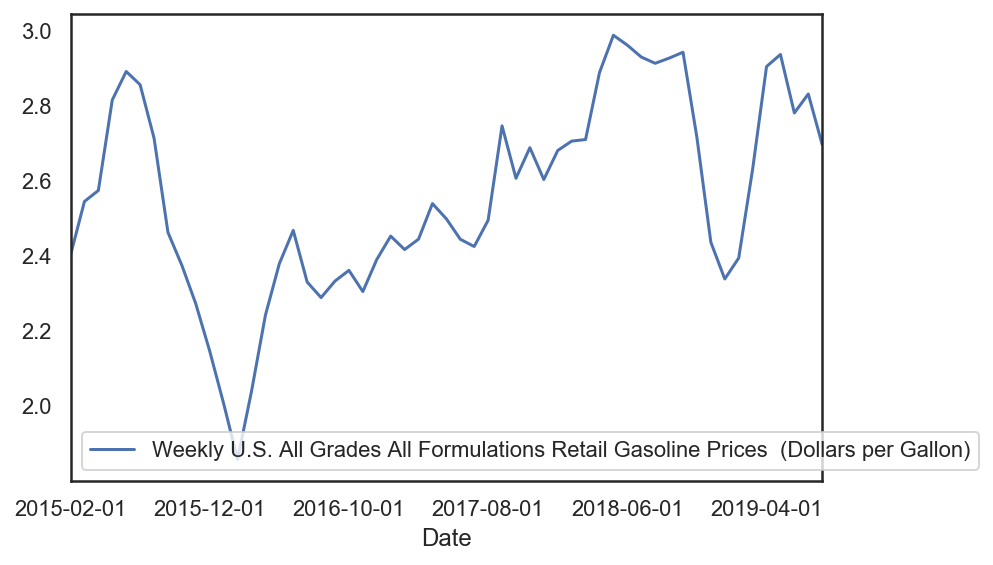

In [205]:
#plot the data .
sns.set(style="white")
df1.plot()

In [206]:
# rest the index ds to the date and y for price 
df2=df1.reset_index()
df2.columns=['ds','y']

In [207]:
# look to the head .
df2.head()

ds         y
0  2015-02-01  2.401250
1  2015-03-01  2.544000
2  2015-04-01  2.573333
3  2015-05-01  2.814400
4  2015-06-01  2.890250

In [208]:
# split the data into train and test , Set four month for testing
train = df2.iloc[:-12]
test = df2.iloc[len(df2)-12:]

In [209]:
# fit the model 
model=Prophet()
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [210]:
#make future prediction 
m=model.make_future_dataframe(periods=-12,freq='MS')

In [212]:
# predict the data .
forcast=model.predict(test.drop(columns="y"))

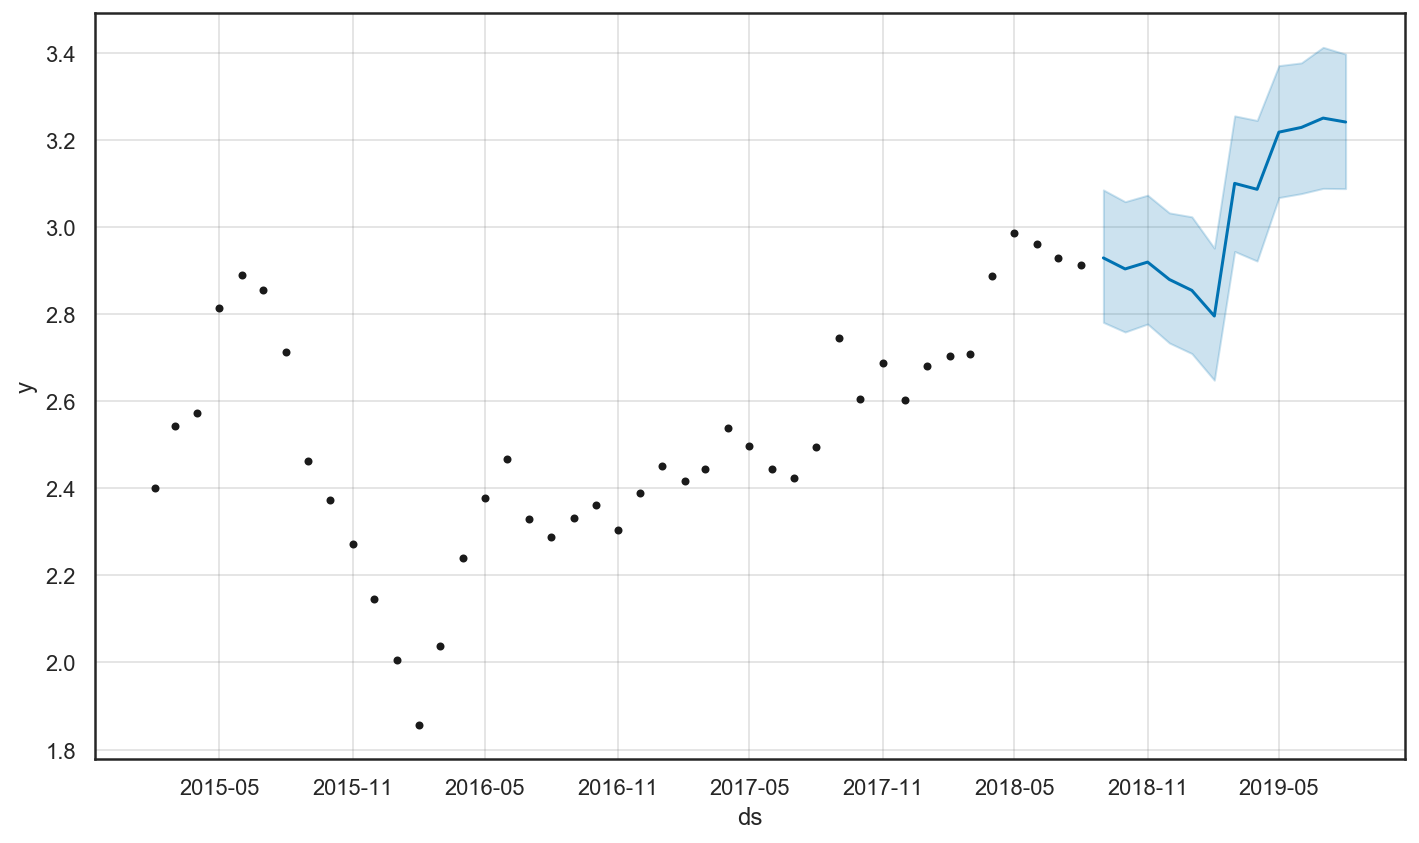

In [213]:
#plot the prediction
model.plot(forcast);

In [214]:
# make a seperate data set for prediction only
prediction = forcast[['ds','yhat']][forcast.ds >='2015']

In [215]:
# set time as index
predictions = prediction.set_index('ds')
tests= test.set_index('ds')

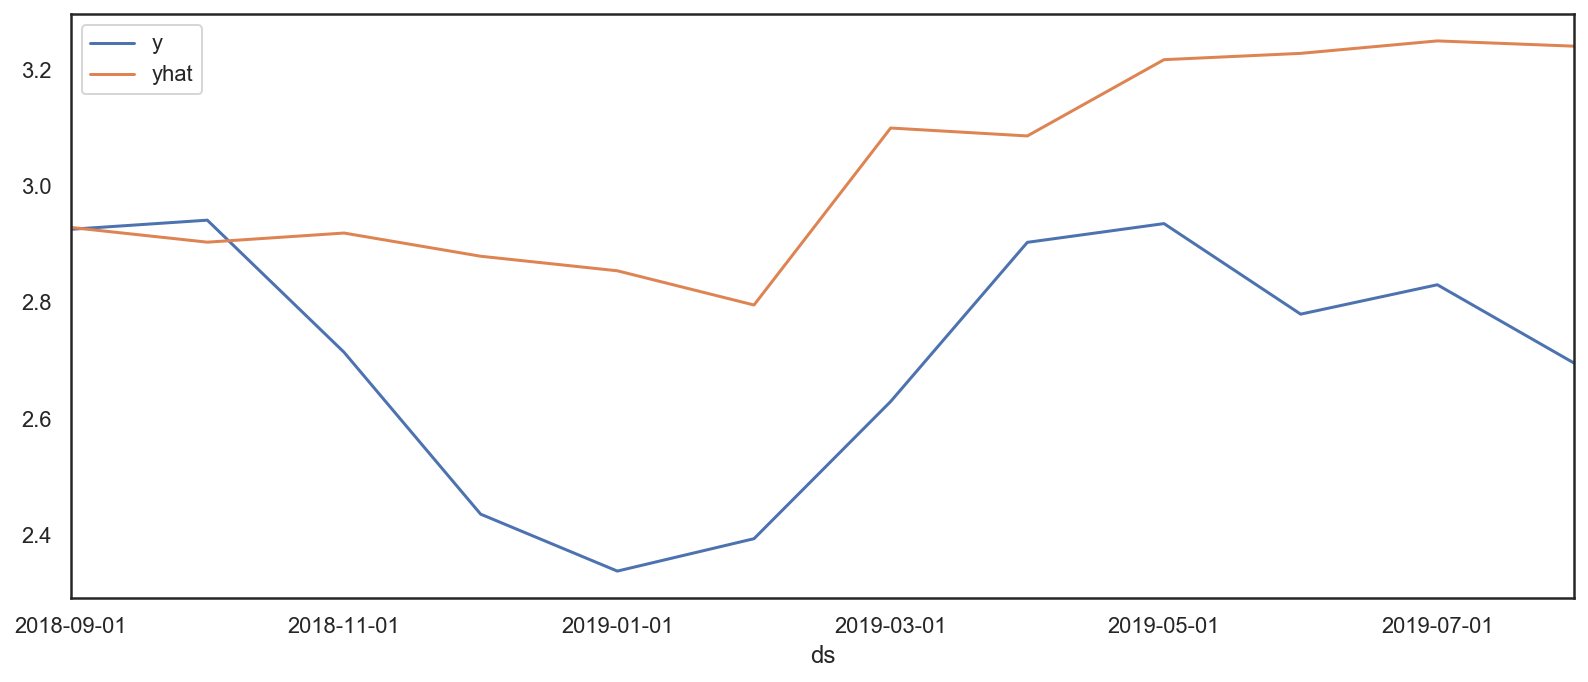

In [219]:
# plot test vs prediction
tests.y.plot(legend=True)
prediction.yhat.plot(figsize=(12,5) , legend=True)

In [222]:
# calculate r2 score
r2_score(tests.y , predictions.yhat)

-2.174993540199929

In [232]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(model, forcast)  # This returns a plotly Figure
py.iplot(fig)

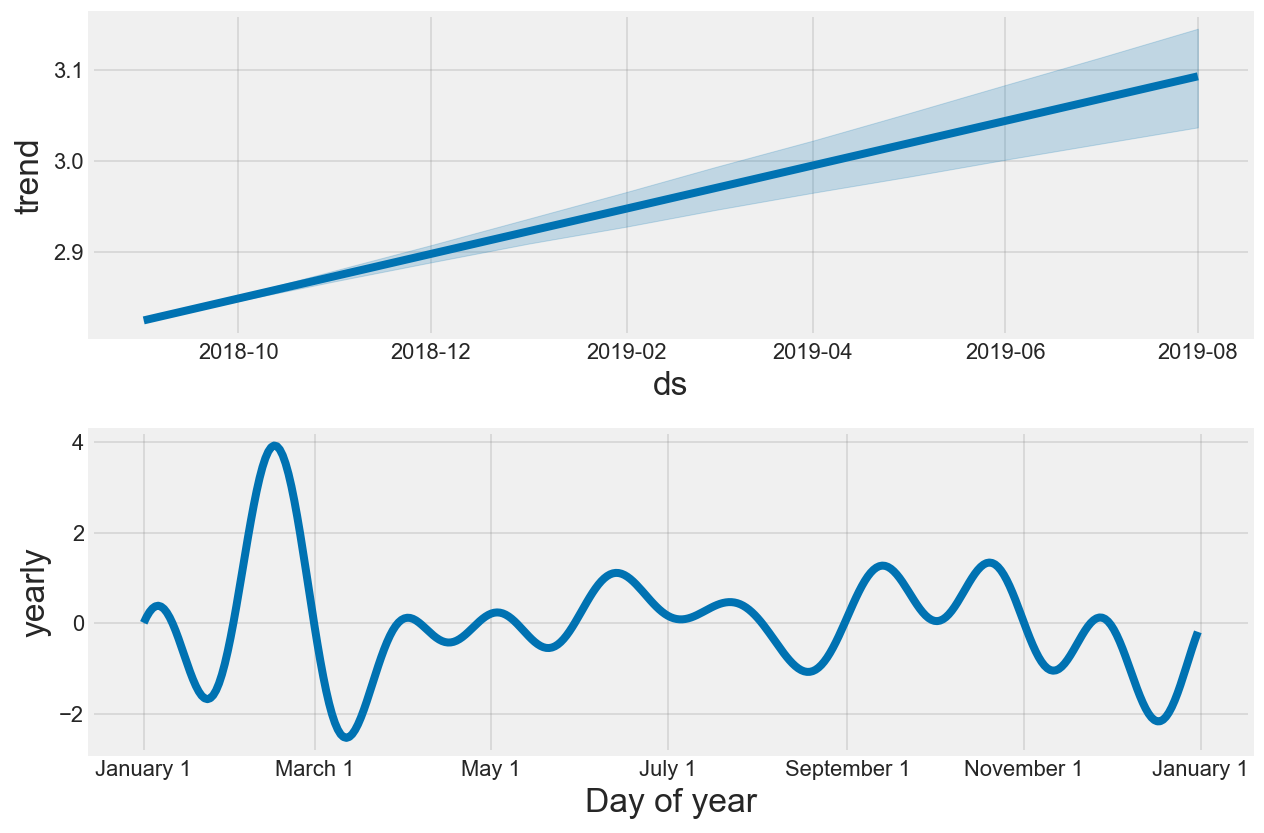

In [233]:
# plot the components .
model.plot_components(forcast);

In [235]:
# import needed library for evaluation.
from fbprophet.diagnostics import cross_validation , performance_metrics

In [236]:
# look to the train shape .
train.shape

(43, 2)

In [237]:
2*43

86

In [238]:
# cross_validation for evaluation the model 
cv=cross_validation(model,initial='86 days',period='86 days',horizon='86 days')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2015-07-10 00:00:00 and 2018-05-07 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [239]:
# look to the head.
cv.head()

ds       yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-08-01  18.563347   18.563347   18.563347  2.712750 2015-07-10
1 2015-09-01 -25.274673  -25.274673  -25.274673  2.461500 2015-07-10
2 2015-10-01   2.083031    2.083031    2.083031  2.373800 2015-07-10
3 2015-11-01  51.622922   51.622922   51.622922  2.271333 2015-10-04
4 2015-12-01 -22.826683  -22.826683  -22.826683  2.145333 2015-10-04

In [240]:
df_pm=performance_metrics(cv)

In [241]:
# show the error 
df_pm.head()

horizon        mse      rmse       mae      mape  coverage
0  8 days  24.565407  4.956350  3.845584  1.850049  0.000000
1 10 days   3.362294  1.833656  1.287266  0.560835  0.000000
2 13 days   3.368728  1.835410  1.294685  0.566841  0.000000
3 15 days   0.104157  0.322734  0.298394  0.119293  0.333333
4 19 days   0.008846  0.094055  0.083927  0.032649  0.666667

In [242]:
# import needed library for ploting .
from fbprophet.plot import plot_cross_validation_metric

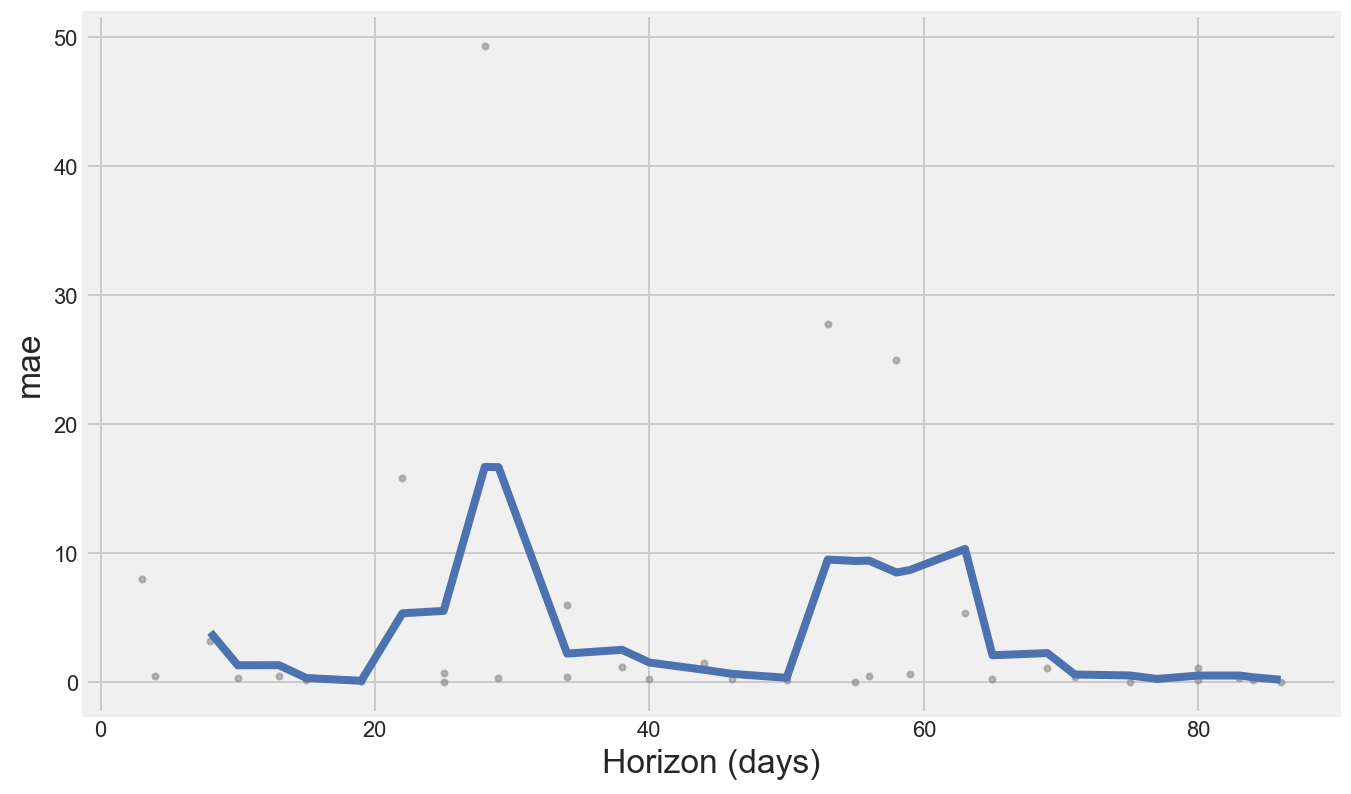

In [245]:
# plot the cross_validation_metric
plot_cross_validation_metric(cv,metric='mae');

# Prophet model for the gasoline Consumed :

In [247]:
# but the column that we want to predict in diff data frame .
d=df[['Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)']]
d.head()

Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)
Date                                                                          
1993-07-01                                           7671.122                 
1993-08-01                                           7749.086                 
1993-09-01                                           7496.345                 
1993-10-01                                           7274.525                 
1993-11-01                                           7422.855

In [248]:
# take the data  from 2015 -2019
d=d[d.index > '2015-01-01']
d.head()

Motor Gasoline Consumed by the Transportation Sector(T/ B per Day)
Date                                                                          
2015-02-01                                           8498.257                 
2015-03-01                                           8717.704                 
2015-04-01                                           8845.658                 
2015-05-01                                           8915.920                 
2015-06-01                                           9064.745

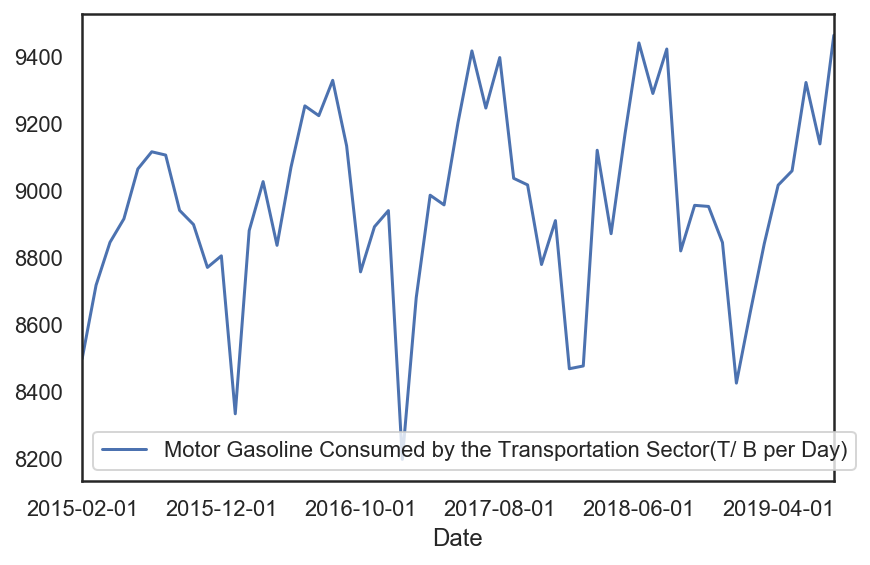

In [249]:
#plot the data .
sns.set(style="white")
d.plot()

#### The data is stationary .

In [250]:
# rest the index ds to the date and y for price 
d1=d.reset_index()
d1.columns=['ds','y']

In [252]:
# look to the head .
d1.head()

ds         y
0  2015-02-01  8498.257
1  2015-03-01  8717.704
2  2015-04-01  8845.658
3  2015-05-01  8915.920
4  2015-06-01  9064.745

In [253]:
# split the data into train and test , Set four month for testing
train_c = d1.iloc[:-12]
test_c = d1.iloc[len(d1)-12:]

In [254]:
# fit the model 
mod=Prophet()
mod.fit(train_c)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [255]:
#make future prediction 
c=mod.make_future_dataframe(periods=-12,freq='MS')

In [256]:
# predict the data .
forcast_c=mod.predict(test_c.drop(columns="y"))

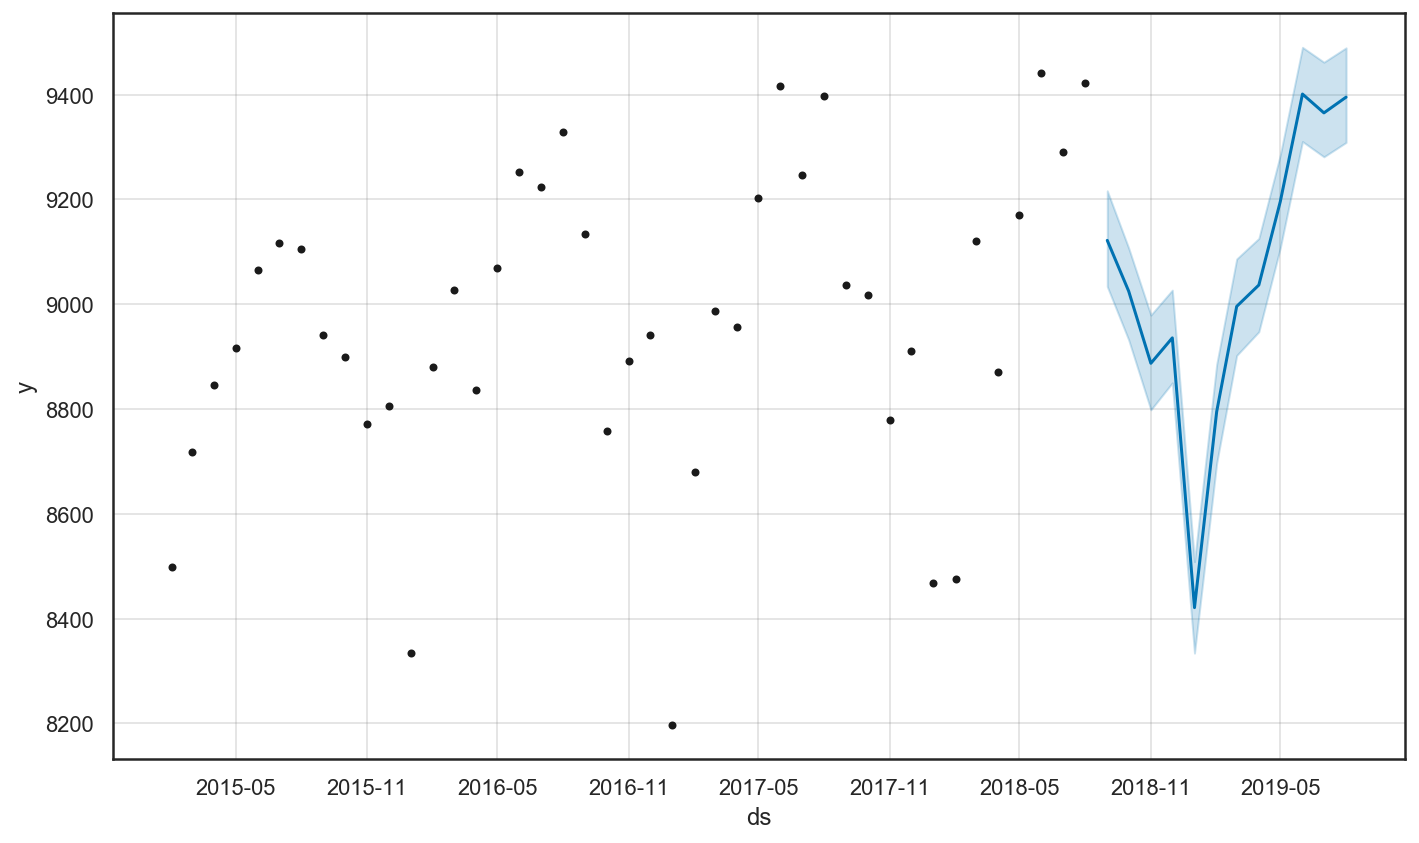

In [257]:
#plot the prediction
mod.plot(forcast_c);

In [258]:
# make a seperate data set for prediction only
pred = forcast_c[['ds','yhat']][forcast_c.ds >='2015']

In [259]:
# set time as index
predi= pred.set_index('ds')
test_c1= test_c.set_index('ds')

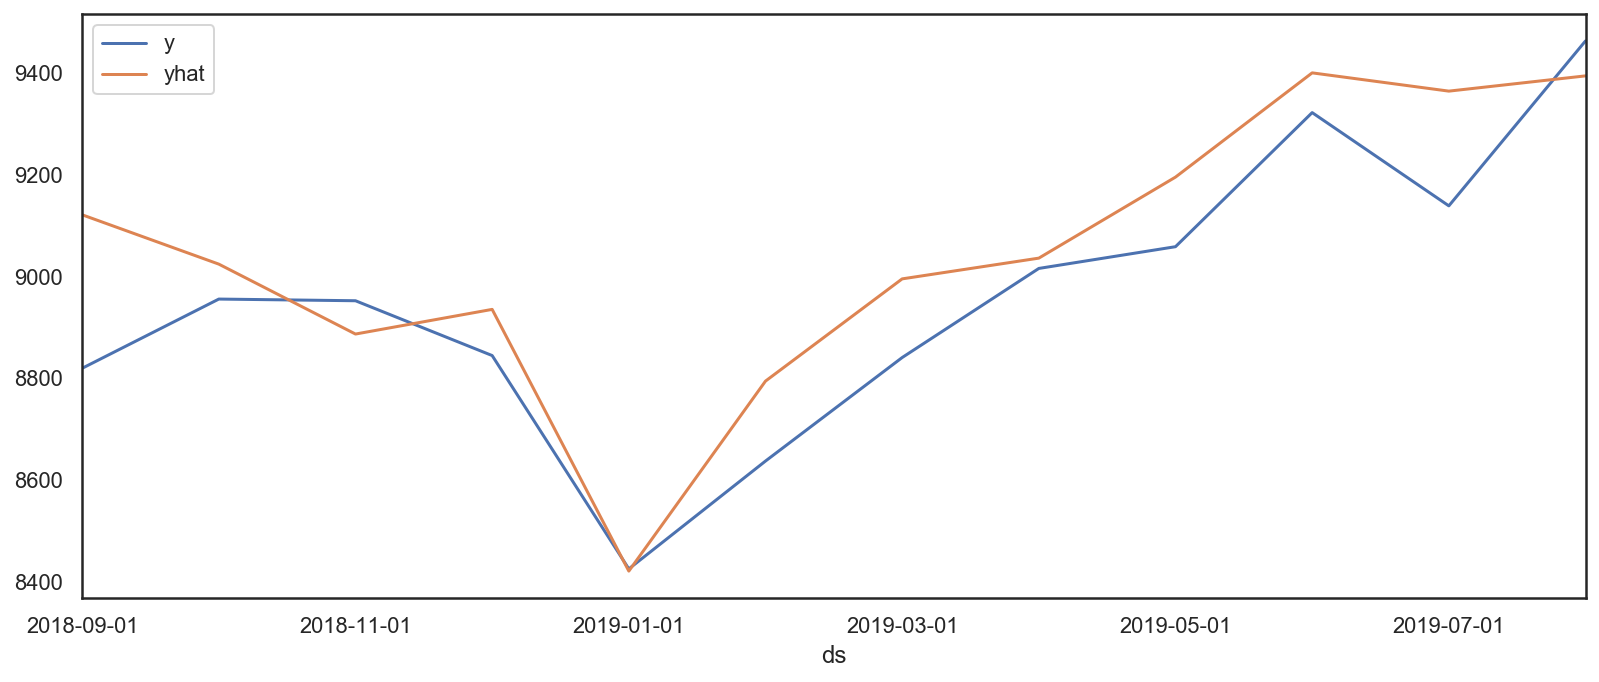

In [260]:
# plot test vs prediction
test_c1.y.plot(legend=True)
pred.yhat.plot(figsize=(12,5) , legend=True)

In [262]:
# calculate r2 score
r2_score(test_c1.y , pred.yhat)

0.7256447409620468

In [263]:
# This returns a plotly Figure
fig = plot_plotly(mod, forcast_c)  
py.iplot(fig)

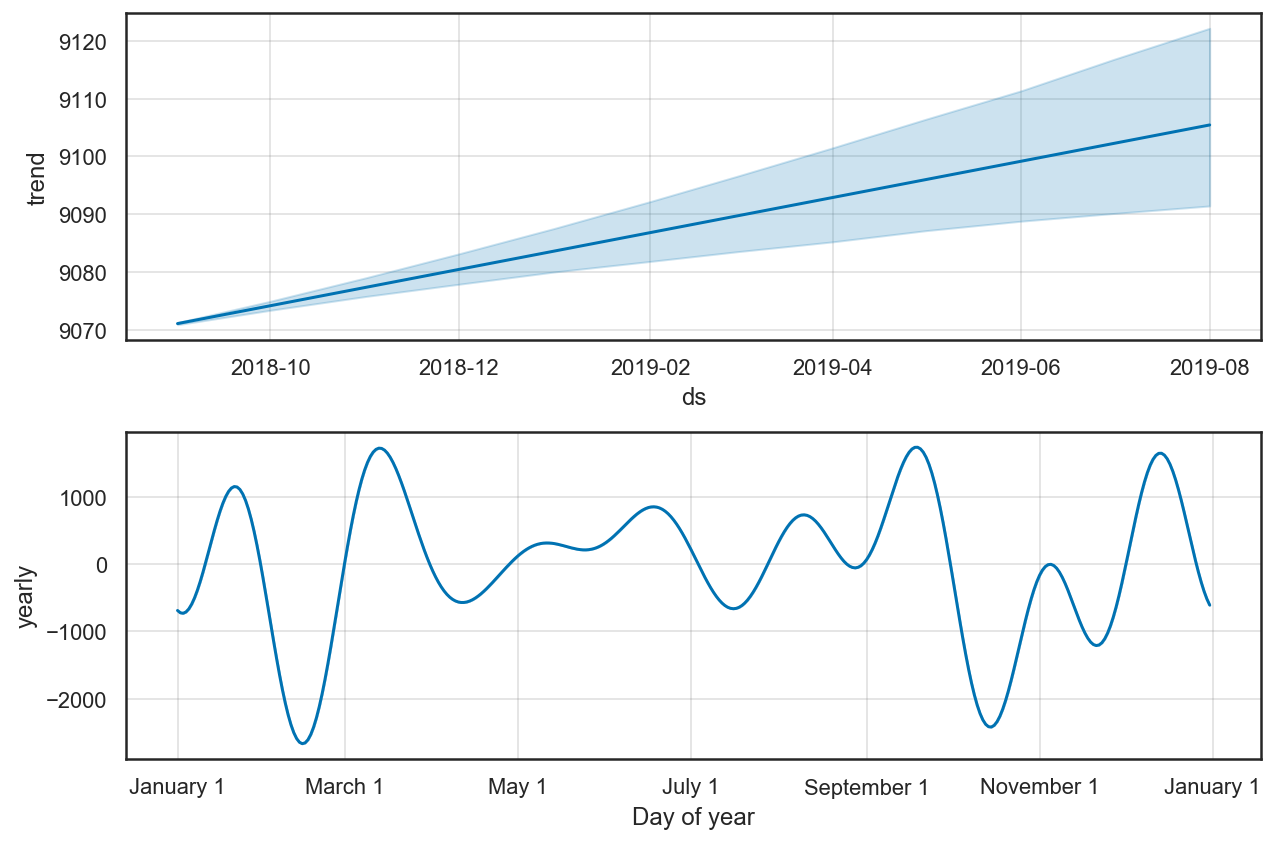

In [264]:
# plot the components .
mod.plot_components(forcast_c);

In [265]:
# cross_validation for evaluation the model 
cv1=cross_validation(mod,initial='86 days',period='86 days',horizon='86 days')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2015-07-10 00:00:00 and 2018-05-07 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [266]:
# look to the head.
cv1.head()

ds           yhat     yhat_lower     yhat_upper         y     cutoff
0 2015-08-01  118104.768834  118104.768815  118104.768852  9106.166 2015-07-10
1 2015-09-01  253289.429244  253289.429202  253289.429279  8941.098 2015-07-10
2 2015-10-01 -350962.617731 -350962.617803 -350962.617664  8898.800 2015-07-10
3 2015-11-01  -37516.799339  -37516.799347  -37516.799333  8770.743 2015-10-04
4 2015-12-01  -79040.770366  -79040.770393  -79040.770342  8805.340 2015-10-04

In [267]:
df_p=performance_metrics(cv1)

In [268]:
# show the error 
df_p.head()

horizon           mse          rmse          mae      mape  coverage
0  8 days  1.383538e+08  11762.390940  9454.699288  1.108109  0.000000
1 10 days  4.419079e+07   6647.615493  3915.682717  0.442858  0.000000
2 13 days  4.422388e+07   6650.103484  4007.263554  0.452819  0.000000
3 15 days  4.689776e+04    216.558912   187.810670  0.020573  0.333333
4 19 days  4.898998e+04    221.336806   194.915315  0.021880  0.333333

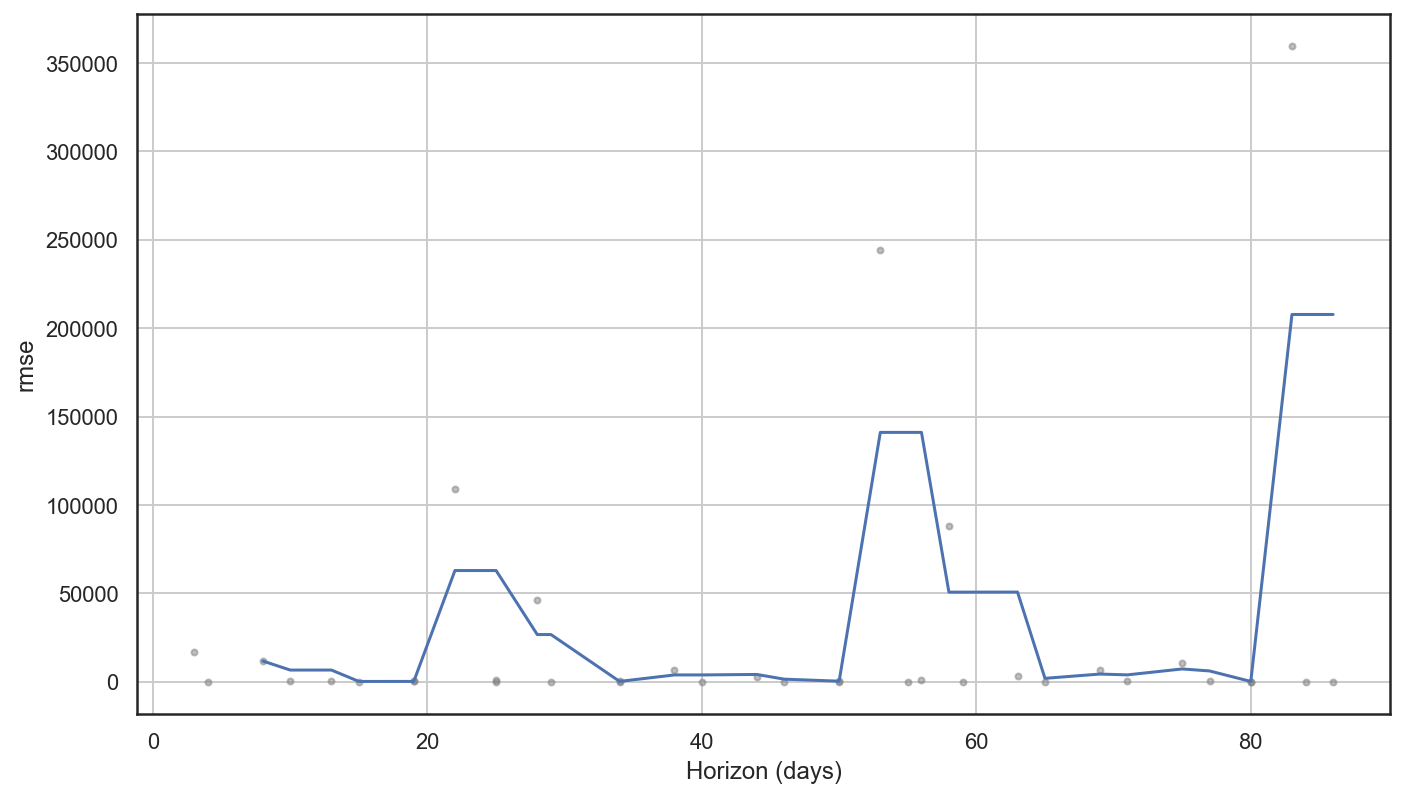

In [270]:
# plot the cross_validation_metric
plot_cross_validation_metric(cv1,metric='rmse');